In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import json
import torch
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from nerfstudio.utils.eval_utils import eval_setup
from inerf.inerf_trainer import load_data_into_trainer
from inerf.inerf_utils import get_corrected_pose, load_eval_image_into_pipeline, get_relative_pose, get_absolute_diff_for_pose, get_image

In [3]:
os.chdir('/workspace')
MODEL_PATH = "/workspace/outputs/jackal_color_wheel_training_data_1/plane-nerf/2024-02-19_174621"
DATA_PATH = "/stored_data/jackal_one_frame_color"
GROUND_TRUTH_PATH = os.path.join(DATA_PATH, "ground_truth.json")
TRANSFORM_FILE = "transforms.json"
with open(GROUND_TRUTH_PATH) as f:
    GROUND_TRUTH = json.load(f)
with open(os.path.join(DATA_PATH, TRANSFORM_FILE)) as f:
    TRANSFORM = json.load(f)

In [4]:
config_path = os.path.join(MODEL_PATH, "config.yml")
config, pipeline, _, _ = eval_setup(
                        Path(config_path),
                        test_mode="inference",
                    )

pipeline = load_eval_image_into_pipeline(pipeline,DATA_PATH,TRANSFORM)

config.pipeline.datamanager.pixel_sampler.num_rays_per_batch = 4096 

trainer = load_data_into_trainer(
    config,
    pipeline,
    plane_optimizer = True
)

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
outputs/jackal_color_wheel_training_data_1/plane-nerf/2024-02-19_174621/nerfstudio_models/step-000009999.ckpt

/workspace/inerf/inerf/inerf_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  camera_to_worlds = torch.cat([camera_to_worlds, tensor([tf]).float()], 0)


Setting up training dataset...

Caching all 1 images.

Output()

Loading PlaneNerfCameraOptimizer


[13:04:12] Saving checkpoints to:                                                                         ]8;id=956098;file:///usr/local/lib/python3.10/dist-packages/nerfstudio/engine/trainer.py\trainer.py]8;;\:]8;id=827499;file:///usr/local/lib/python3.10/dist-packages/nerfstudio/engine/trainer.py#136\136]8;;\
           outputs/jackal_color_wheel_training_data_1/plane-nerf/2024-02-19_174621/nerfstudio_models                    

Loading latest Nerfstudio checkpoint from load_dir...


Done loading Nerfstudio checkpoint from 
outputs/jackal_color_wheel_training_data_1/plane-nerf/2024-02-19_174621/nerfstudio_models/step-000009999.ckpt

In [5]:
trainer.pipeline.datamanager.KERNEL_SIZE = 5
trainer.pipeline.datamanager.THRESHOLD = 40
trainer.pipeline.datamanager.METHOD = "sift"
trainer.pipeline.datamanager.get_inerf_batch()  

Number of keypoints:  85
Number of rays:  4113
Reduce the number of rays
Final number of rays:  4096


In [6]:
ground_truth_poses = []
for _ , batch in pipeline.datamanager.fixed_indices_train_dataloader:
    tf = GROUND_TRUTH["frames"][int(batch['image_idx'])]["transform_matrix"]
    tf = np.asarray(tf)
    tf = tf[:3, :4 ]
    ground_truth_poses.append(tf)
ground_truth_poses = torch.tensor(ground_truth_poses).to(pipeline.device)

In [7]:
original_img = cv2.imread(os.path.join(DATA_PATH, GROUND_TRUTH["frames"][0]["file_path"]))
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

In [8]:
train_loop = 30
n = 10
lr_max = 5e-3
lr_min = 1e-4
store = torch.tensor([])
imgs = []
from nerfstudio.data.dataparsers.base_dataparser import transform_poses_to_original_space
original_camera_pose = trainer.pipeline.datamanager.train_dataparser_outputs.cameras.camera_to_worlds.to("cuda:0")
original_camera_pose = transform_poses_to_original_space(
    original_camera_pose,
    trainer.pipeline.datamanager.train_dataparser_outputs.dataparser_transform.to(trainer.pipeline.device),
    trainer.pipeline.datamanager.train_dataparser_outputs.dataparser_scale,
    "opengl"
)
print(original_camera_pose)

corrected_pose = get_corrected_pose(trainer)
#print(corrected_pose)
relative_pose = get_relative_pose(ground_truth_poses, corrected_pose)
t_diff, r_diff = get_absolute_diff_for_pose(relative_pose)
#Get averrage absolute translation and rotation error
print("Average translation error: ", torch.mean(t_diff))
print("Average rotation error: ", torch.mean(r_diff))
rendered_img = get_image(trainer.pipeline, original_camera_pose.float()) #Vital note render with original camera pose
imgs.append(rendered_img["rgb"].detach().cpu().numpy())

store = torch.cat((store, torch.tensor([[0, torch.mean(t_diff), torch.mean(r_diff)]])), 0)

for i in range(train_loop):
    for j in range(n):
        lr = lr_min + (lr_max - lr_min) * (i / train_loop)
        loss = trainer.train_iteration_inerf(i*n + j,optimizer_lr = 1e-3)
    corrected_pose = get_corrected_pose(trainer)
    #print(corrected_pose)
    relative_pose = get_relative_pose(ground_truth_poses, corrected_pose)
    t_diff, r_diff = get_absolute_diff_for_pose(relative_pose)

    #Get averrage absolute translation and rotation error
    print("Average translation error: ", torch.mean(t_diff))
    print("Average rotation error: ", torch.mean(r_diff))
    print(loss)
    rendered_img = get_image(trainer.pipeline, original_camera_pose.float()) #Vital note render with original camera pose
    imgs.append(rendered_img["rgb"].detach().cpu().numpy())
    
    store = torch.cat((store, torch.tensor([[i+1, torch.mean(t_diff), torch.mean(r_diff)]])), 0)

tensor([[[ 0.8717,  0.3331, -0.3593, -1.5590],
         [-0.4895,  0.6245, -0.6086, -2.3829],
         [ 0.0217,  0.7064,  0.7075,  2.5000]]], device='cuda:0')
Average translation error:  tensor(0.1000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.1745, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average translation error:  tensor(0.0946, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.1828, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'loss': tensor(0.0279, device='cuda:0', grad_fn=<SqueezeBackward0>)}
Average translation error:  tensor(0.0671, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.1812, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'loss': tensor(0.0274, device='cuda:0', grad_fn=<SqueezeBackward0>)}
Average translation error:  tensor(0.0263, device='cuda:0', dtype=torch.f

Text(0.5, 1.0, 'Rendered image')

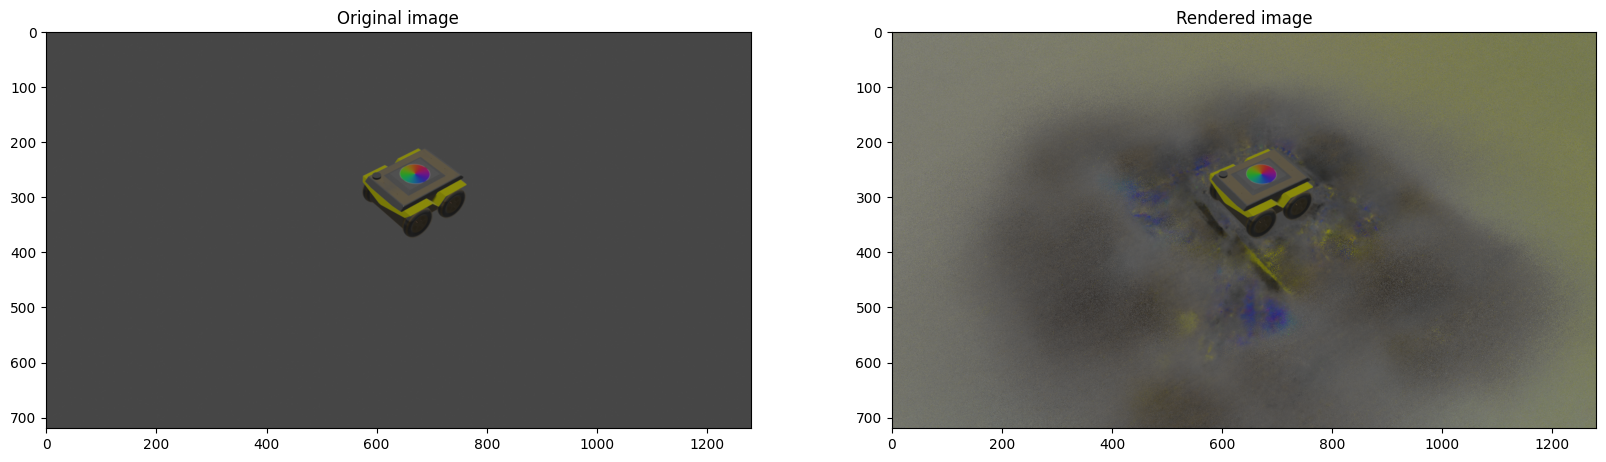

In [9]:
#Plot original image and rendered image
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(original_img)
ax[0].set_title("Original image")
ax[1].imshow(imgs[-1])
ax[1].set_title("Rendered image")

Text(0.5, 1.0, 'Rendered image')

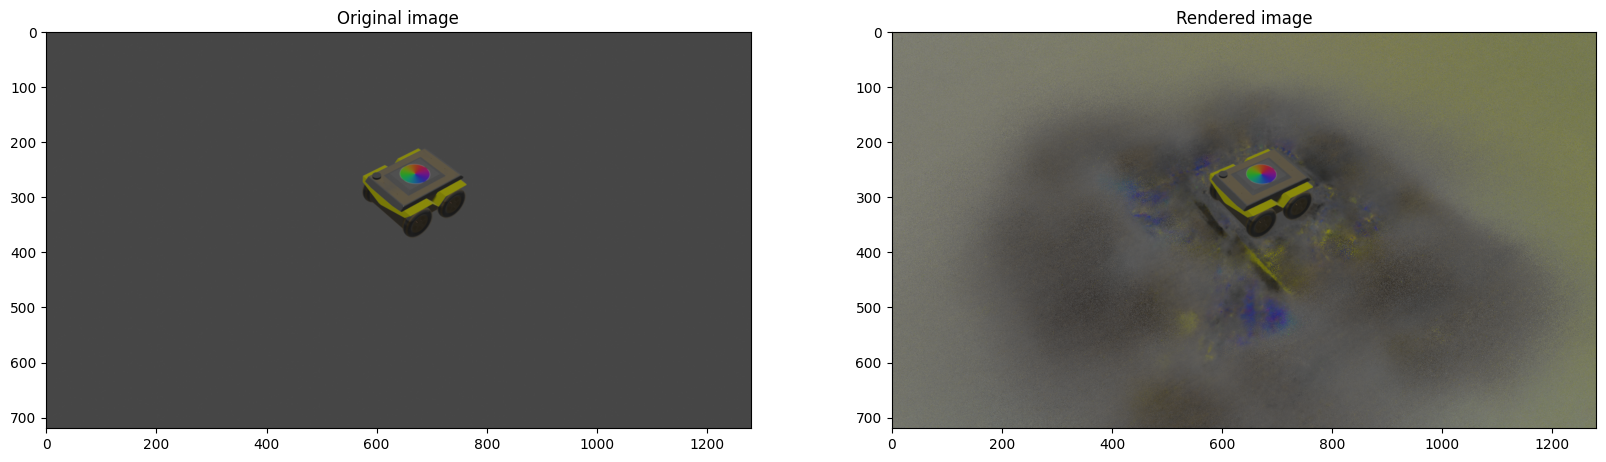

In [10]:
#Plot original image and rendered image
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(original_img)
ax[0].set_title("Original image")
ax[1].imshow(imgs[-1])
ax[1].set_title("Rendered image")

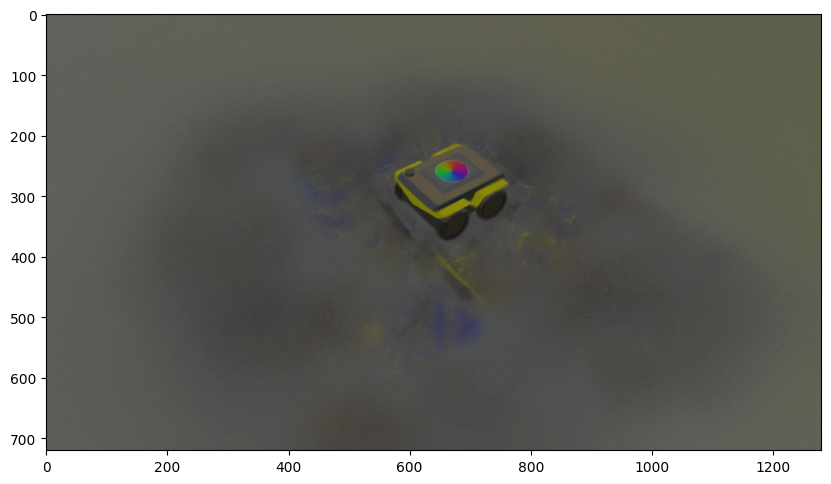

In [11]:
#Overlay original image and rendered image
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(imgs[-1])
ax.imshow(original_img, alpha=0.5)

In [25]:
cv2_images = [(img * 0.5 + original_img/255 * 0.5) for img in imgs]
H,W,_ = cv2_images[0].shape
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'mp4v' codec for MP4 format
out = cv2.VideoWriter('output_video.mp4', fourcc, 10.0, (W, H))
for i in range(len(cv2_images)):
    #min_pil = cv2_images[i].min()
    #max_pil = cv2_images[i].max()
    #cv2_images[i] = (cv2_images[i] - min_pil) / (max_pil - min_pil)
    cv2_images[i] = (cv2_images[i] * 255).astype(np.uint8)
    cv2_images[i] = cv2.cvtColor(cv2_images[i], cv2.COLOR_RGB2BGR)
    out.write(cv2_images[i])

out.release()